In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import core.utils as utils
import core.bayes as bayes

## Validation data

In [2]:
s, d = torch.load('data/weak_lensing.pt')
s, d = s.cuda(), d.cuda()

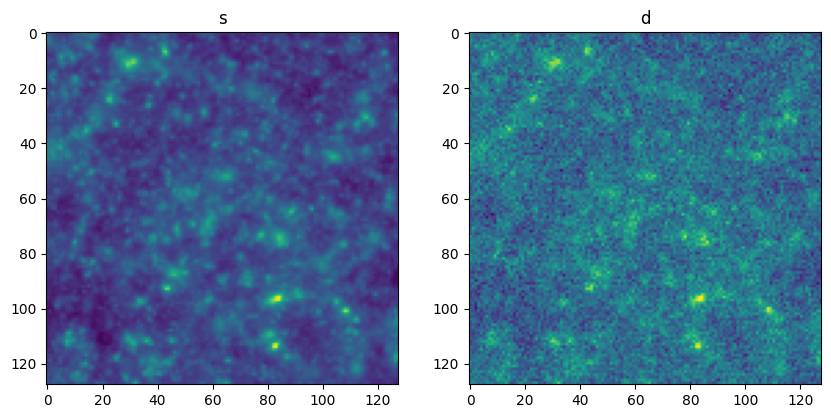

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(s[0].cpu())
ax2.imshow(d[0].cpu())
ax1.set_title("s")
ax2.set_title("d")
plt.show()

## Metrics

## Baseline

We try to sample different realizations from $p(\phi(s_0)|d_0)$ by performing following procedure:
1. Denoise $d_0$ by performing gradient descent with loss $\mathcal{L} = \mathbb{E}_n||\phi(s + n) - \phi(d_0)||^2\to\min$ starting from white noise image $s$
2. Calculate WPH statistics $\phi$ of reconstructed image $\tilde{s}$

In [3]:
wph_op = bayes.create_wph_operator(d[0])

In [4]:
sample_size = 5
loss_threshold = 10

y_list = []
d_coeffs = wph_op.apply(d[0], norm='auto')

while len(y_list) < sample_size:
    y, loss = bayes.denoise(wph_op, d_coeffs, np.random.randn(*d[0].shape), verbose=False)
    if loss < loss_threshold:
        y_list.append(y)
        print('final loss', loss)
        
y_list = np.stack(y_list)

/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/pywph/wph_operator.py:803: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 = xpsi1_k1 - mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


final loss 5.477194309234619
final loss 5.429141044616699
final loss 5.225465774536133
final loss 4.468563556671143
final loss 4.179920673370361


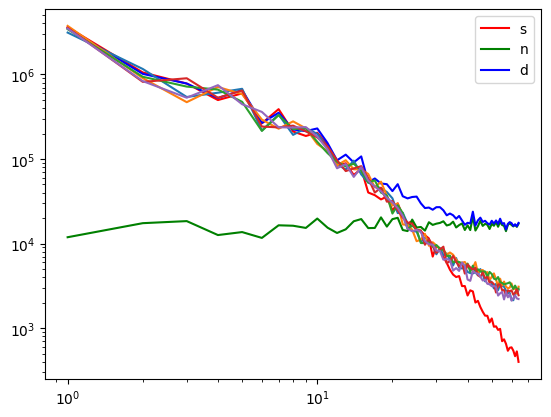

In [6]:
for x, name, c in zip([s[0], d[0] - s[0], d[0]], ["s", "n", "d"], ["r", "g", "b"]):
    k, bins = utils.power_spectrum(x.cpu())
    plt.loglog(k, bins, label=name, c=c)
    
for y in y_list:
    k, bins = utils.power_spectrum(y)
    plt.loglog(k, bins)
    
plt.legend()
plt.show()

In [53]:
stat = wph_op.apply(y_list, norm='auto')
s_coeffs = wph_op.apply(s[0], norm='auto')

mean = torch.cat([stat.real.mean(dim=0), stat.imag.mean(dim=0)])
std = torch.cat([stat.real.std(dim=0), stat.imag.std(dim=0)]) + 1e-8
true = torch.cat([s_coeffs.real, s_coeffs.imag])

loglike = -torch.log(2 * np.pi * std**2) / 2 - (mean - true)**2 / 2 / std**2
loglike = loglike.cpu().numpy()

In [58]:
wph = wph_op(d[0], ret_wph_obj=True)
j_index = wph.wph_coeffs_indices[:, 0]

j_list = np.unique(j_index)
loglike_list = [[], []]

for j in j_list:
    mask = np.concatenate([j_index == j, np.zeros(len(s_coeffs) - len(j_index), dtype=bool)])
    real_mask = np.concatenate([mask, np.zeros(len(mask), dtype=bool)])
    imag_mask = np.concatenate([np.zeros(len(mask), dtype=bool), mask])
    
    loglike_list[0].append(loglike[real_mask].mean().item())
    loglike_list[1].append(loglike[imag_mask].mean().item())
    
loglike_list = np.array(loglike_list)

In [48]:
np.zeros(len(s_coeffs) - len(j_index))

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [57]:
loglike.mean()

-0.9738277

In [50]:
loglike[imag_mask].shape

torch.Size([8762])

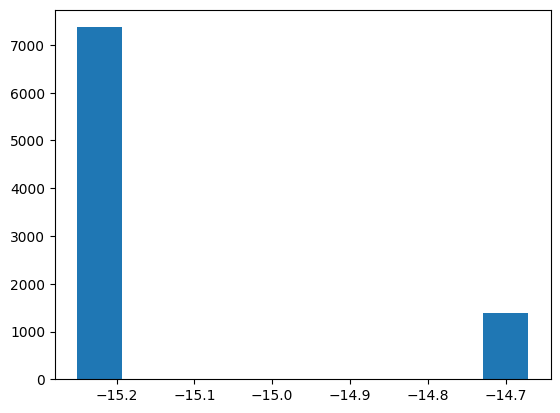

In [47]:
plt.hist(loglike[imag_mask].cpu())
plt.show()

In [30]:
len(real_mask), len(loglike)

(8762, 8762)

In [41]:
loglike.mean()

tensor(-0.9738, device='cuda:0')

In [45]:
loglike[real_mask]

tensor([-14.6709, -14.6709, -14.6709,  ..., -15.2504, -15.2504, -15.2504],
       device='cuda:0')

In [56]:
loglike_list

array([[-10.02581596,  -1.15346134,   0.26462203,  -0.33032319,
          2.69810104,   1.62433481],
       [  5.17762899,  -2.47342467,   0.19783239,  -0.98160851,
          2.46500802,   1.59985673]])

In [10]:
wph = wph_op(d[0], ret_wph_obj=True)

In [13]:
len(wph.wph_coeffs)

4372

In [14]:
len(loglike)

4381

In [23]:
np.unique(wph.wph_coeffs_indices[:, 0])

array([0, 1, 2, 3, 4, 5])